## Stochastic Financial Planning and Control
### Goal based investing using utility and stochastic programming

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
import cvxpy as cp

In [2]:
# Use past 10 years historical data - ETFs used
spy = pd.read_csv('SPY.csv')
agg = pd.read_csv('AGG.csv')

# convert price data into daily yield data
spy_log_ret = np.log(spy['Adj Close'] / spy['Adj Close'].shift(1))
agg_log_ret = np.log(agg['Adj Close'] / agg['Adj Close'].shift(1))

# df_logret is daily log return of stock and bond
df_logret = pd.DataFrame({'stock' : spy_log_ret, 'bond' : agg_log_ret})
df_logret.loc[0, ['stock','bond']] = 0.0 

In [12]:
# set parameter
_mu = df_logret.mean() * 251 
_sigma = df_logret.cov() * 251
print("average annual stock return is ", round(_mu.iloc[0],4), " and bond return is ",round(_mu.iloc[1],4) )

mu = _mu.values.T
sigma = _sigma.values
print("stock vol is ", round(_sigma.iloc[0,0],4), " bond vol is ",round(_sigma.iloc[1,1],4), " cov is ",round(_sigma.iloc[0,1],4))

# generate stock and bond return scenario under gausian distribution
num_samples = 10000
stock, bond = np.random.multivariate_normal(mu, sigma, num_samples).T

average annual stock return is  0.1188  and bond return is  0.0138
stock vol is  0.0307  bond vol is  0.0026  cov is  0.0007


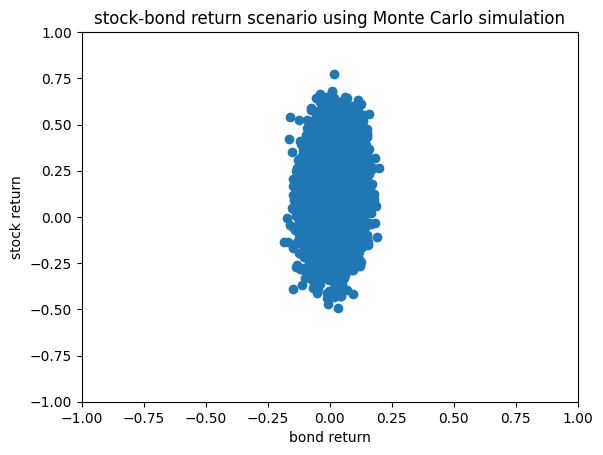

In [14]:
plt.scatter(bond, stock)
plt.xlabel('bond return')
plt.ylabel('stock return')
plt.title("stock-bond return scenario using Monte Carlo simulation")
plt.xlim(-1,+1)
plt.ylim(-1,+1)
plt.show()

In [15]:
# cluster the performance for the simulated data to reduce dimensionality
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters).fit(np.transpose([bond, stock]))

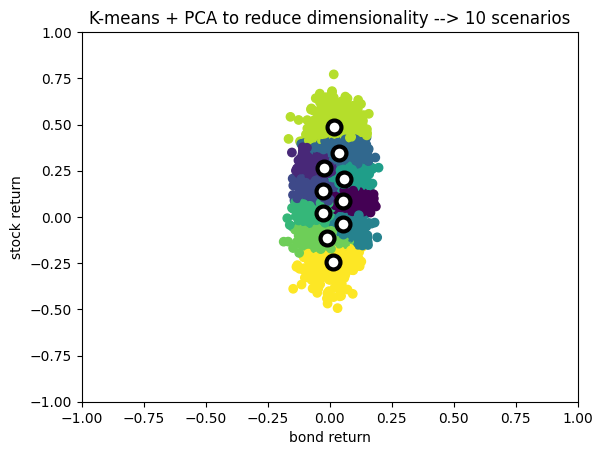

In [18]:
# K-means clustering + PCA (mean-covariance matrix)
plt.scatter(bond, stock, c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=100, 
            color='white', edgecolors='black', linewidths=3)
plt.xlabel('bond return')
plt.ylabel('stock return')
plt.title('K-means + PCA to reduce dimensionality --> 10 scenarios')
plt.xlim(-1,+1)
plt.ylim(-1,+1)
plt.show()

In [21]:
print("Probability of each scenario")
prob = np.zeros(num_clusters)
scenarios = 1 + kmeans.cluster_centers_

for i in range(num_clusters):
    prob[i] = np.count_nonzero(kmeans.labels_==i)/num_samples
    print("cluster ", i, " : ", round(prob[i]*100,2), "%")
    print("stock return: ", round(scenarios[i][1]-1,4), " bond return is: ", round(scenarios[i][0]-1,4))

Probability of each scenario
cluster  0  :  13.41 %
stock return:  0.087  bond return is:  0.0543
cluster  1  :  10.26 %
stock return:  0.2667  bond return is:  -0.0218
cluster  2  :  13.53 %
stock return:  0.1405  bond return is:  -0.0263
cluster  3  :  9.98 %
stock return:  0.3472  bond return is:  0.0365
cluster  4  :  9.68 %
stock return:  -0.0392  bond return is:  0.0533
cluster  5  :  13.14 %
stock return:  0.2055  bond return is:  0.0565
cluster  6  :  12.71 %
stock return:  0.0232  bond return is:  -0.0264
cluster  7  :  8.9 %
stock return:  -0.1136  bond return is:  -0.012
cluster  8  :  4.48 %
stock return:  0.4885  bond return is:  0.0192
cluster  9  :  3.91 %
stock return:  -0.2436  bond return is:  0.0123


In [22]:
# building two-stage stochastic program considering utility
x_0 = cp.Variable(2)
y = cp.Variable(num_clusters)
w = cp.Variable(num_clusters)

q = 1
r = 10

init_amount = 100
goal_amount = 108

probability = cp.Problem(
    cp.Maximize(prob.T @ (q*y - r*w)),
    [
    sum(x_0) == init_amount,
    scenarios @ x_0 - y + w == goal_amount * np.ones(num_clusters),
    x_0 >= 0,
    y >= 0,
    w >= 0
    ]
)

probability.solve(solver=cp.ECOS)

-37.03984162603062

In [23]:
expected_return = (goal_amount + np.dot(prob, y.value - w.value)) / init_amount - 1
print("optimal allocation for stock = ", round(x_0.value[0],2), " bond = ", round(x_0.value[1],2))
print("expected_retun is ", round(100* expected_return, 2),"%")

optimal allocation for stock =  36.27  bond =  63.73
expected_retun is  8.25 %


Text(0.5, 1.0, 'Investment return for each scenario')

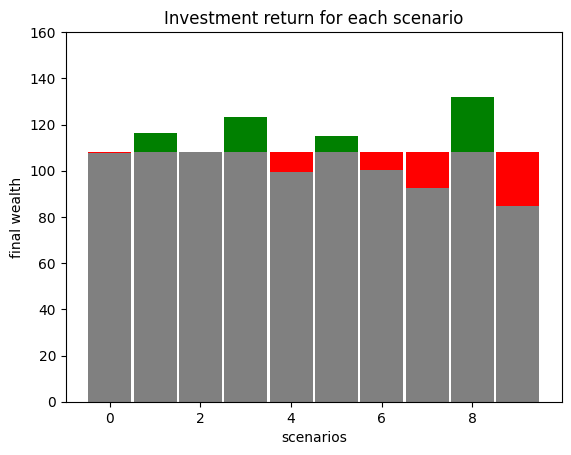

In [27]:
fig, ax = plt.subplots(1,1)
ax.bar(range(num_clusters), np.round(goal_amount+y.value,2), color='green', width=0.95)
ax.bar(range(num_clusters), goal_amount, color='red', width=0.95)
ax.bar(range(num_clusters), np.round(goal_amount-w.value,2), color='grey', width=0.95)
ax.set_ylim([0, 160])
ax.set_xlabel('scenarios')
ax.set_ylabel('final wealth')
plt.title('Investment return for each scenario')